In [12]:
import os
import torch
import numpy as np
import json
from easydict import EasyDict as edict
from test_utils import load_dataset, LoaderSampler, tensor2img, get_Z_pushed_loader_stats
from core.my_solver import Solver
from core.fid_score import calculate_frechet_distance
import matplotlib.pyplot as plt

args = edict({
    'img_size': 128,
    'num_domains': 2,
    'latent_dim': 16,
    'hidden_dim': 512,
    'style_dim': 64, 
    'lambda_reg': 1.0,
    'lambda_cyc': 1.0,
    'lambda_sty': 1.0,
    'lambda_ds': 1.0,
    'ds_iter': 100000,
    'w_hpf': -1.0,
    'randcrop_prob': 0.5,
    'total_iters': 100000,
    'resume_iter': 0,
    'batch_size': 16,
    'val_batch_size': 32,
    'lr': 1e-4,
    'f_lr': 1e-6,
    'beta1': 0.0,
    'beta2': 0.99,
    'weight_decay': 1e-4,
    'num_outs_per_domain': 10,
    'mode': 'test', 
    'num_workers': 4,
    'seed': 777,
    'train_img_dir': '/cache/selikhanovych/ot/data/outdoor2church_train',
    'val_img_dir': '/cache/selikhanovych/ot/data/outdoor2church_test',
    'sample_dir': 'expr/samples',
    'checkpoint_dir': '/cache/selikhanovych/ot/checkpoints/stargan-v2/stargan-v2/outdoor_church_128/checkpoints',
    'eval_dir': 'expr/eval',
    'result_dir': 'expr/results',
    'src_dir': 'assets/representative/celeba_hq/src',
    'ref_dir': 'assets/representative/celeba_hq/ref',
    'inp_dir': 'assets/representative/custom/female',
    'out_dir': 'assets/representative/celeba_hq/src/female',
    'wing_path': 'expr/checkpoints/wing.ckpt',
    'lm_path': 'expr/checkpoints/celeba_lm_mean.npz',
    'print_every': 10,
    'sample_every': 4000,
    'save_every': 4000,
    'eval_every': 4000,
    
    'target_dataset': 'church',
    'OUTPUT_PATH': '/cache/selikhanovych/ot/checkpoints/stargan-v2/outdoor_church_128',
    'domains': {
        'source': 'outdoor',
        'target': 'church',
    },
    'train_a': '/cache/selikhanovych/ot/data/outdoor2church_train_outdoor',
    'train_b': '/cache/selikhanovych/ot/data/outdoor2church_train_church', 
    'test_a': '/cache/selikhanovych/ot/data/outdoor2church_test_outdoor',
    'test_b': '/cache/selikhanovych/ot/data/outdoor2church_test_church',
    
    'n_epochs': 1
})

In [5]:
DATASET1, DATASET1_PATH = 'outdoor', '../data/outdoor_128.hdf5'
DATASET2, DATASET2_PATH = 'church', '../data/church_128.hdf5'

IMG_SIZE = 128
device = 'cuda:0'

filename = 'stats/{}_{}_test.json'.format(DATASET2, IMG_SIZE)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
del data_stats

train_loader_a, test_loader_a = load_dataset(DATASET1, DATASET1_PATH,
                                             img_size=IMG_SIZE, batch_size=32)
train_loader_b, test_loader_b = load_dataset(DATASET2, DATASET2_PATH,
                                             img_size=IMG_SIZE, batch_size=32)

torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)

X_fixed = X_sampler.sample(10)
Y_fixed = Y_sampler.sample(10)

X_test_fixed = X_test_sampler.sample(10)
Y_test_fixed = Y_test_sampler.sample(10)

Keys: <KeysViewHDF5 ['imgs']>
Keys: <KeysViewHDF5 ['imgs']>


In [6]:
solver = Solver(args)
iteration = 72001
solver._load_checkpoint(iteration)

Number of parameters of generator: 33632003
Number of parameters of mapping_network: 2438272
Number of parameters of style_encoder: 20799744
Number of parameters of discriminator: 20735106
Initializing generator...
Initializing mapping_network...
Initializing style_encoder...
Initializing discriminator...
Loading checkpoint from /cache/selikhanovych/ot/checkpoints/stargan-v2/stargan-v2/outdoor_church_128/checkpoints/072001_nets_ema.ckpt...


In [7]:
nets_ema = solver.nets_ema
nets_ema.mapping_network.eval()
nets_ema.generator.eval()

num_calculation_fid = 10
fid_values = []

for i in range(num_calculation_fid):
    mu, sigma = get_Z_pushed_loader_stats(nets_ema, args.domains, args, device,
                                      test_loader_a,
                                      n_epochs=args.n_epochs)
    fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
    print(f"FID = {fid}")
    fid_values.append(fid)
    
fid_values = np.array(fid_values)
fid_mean = np.mean(fid_values)
fid_std = np.std(fid_values)
print("--------")
print(f"Mean FID = {fid_mean}")
print(f"Std FID = {fid_std}")

Calculating evaluation metrics...
Number of domains: 2
Compute FID for outdoor2church


  0%|                                                                                                                                                                                                                | 0/470 [00:00<?, ?it/s]libibverbs: Warning: couldn't open config directory '/etc/libibverbs.d'.
libibverbs: Warning: no userspace device-specific driver found for /sys/class/infiniband_verbs/uverbs0
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 470/470 [03:26<00:00,  2.27it/s]


FID = 12.017607598651125
Calculating evaluation metrics...
Number of domains: 2
Compute FID for outdoor2church


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 470/470 [01:26<00:00,  5.45it/s]


FID = 12.04266726079993
Calculating evaluation metrics...
Number of domains: 2
Compute FID for outdoor2church


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 470/470 [01:26<00:00,  5.43it/s]


FID = 11.984182592693884
Calculating evaluation metrics...
Number of domains: 2
Compute FID for outdoor2church


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 470/470 [01:25<00:00,  5.47it/s]


FID = 12.079961726974147
Calculating evaluation metrics...
Number of domains: 2
Compute FID for outdoor2church


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 470/470 [01:26<00:00,  5.40it/s]


FID = 12.233788403000574
Calculating evaluation metrics...
Number of domains: 2
Compute FID for outdoor2church


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 470/470 [01:30<00:00,  5.18it/s]


FID = 11.908209398869104
Calculating evaluation metrics...
Number of domains: 2
Compute FID for outdoor2church


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 470/470 [01:28<00:00,  5.31it/s]


FID = 12.061943853147284
Calculating evaluation metrics...
Number of domains: 2
Compute FID for outdoor2church


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 470/470 [01:31<00:00,  5.14it/s]


FID = 12.137902069160504
Calculating evaluation metrics...
Number of domains: 2
Compute FID for outdoor2church


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 470/470 [01:27<00:00,  5.37it/s]


FID = 11.941822880219718
Calculating evaluation metrics...
Number of domains: 2
Compute FID for outdoor2church


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 470/470 [01:28<00:00,  5.32it/s]


FID = 11.94828228001191
--------
Mean FID = 12.035636806352818
Std FID = 0.09384595060013402


In [10]:
eval_trg_domain = args.domains['target']
eval_src_domain = args.domains['source']

domains = os.listdir(args.val_img_dir)
domains.sort()

final_trg_index = -1
final_src_index = -1

for trg_idx, trg_domain in enumerate(domains):
    src_domains = [x for x in domains if x != trg_domain]
    for src_idx, src_domain in enumerate(src_domains):
        if src_domain == eval_src_domain and trg_domain == eval_trg_domain:
            final_trg_index = trg_idx
            final_src_index = src_idx
            
print(final_trg_index, final_src_index)

0 0


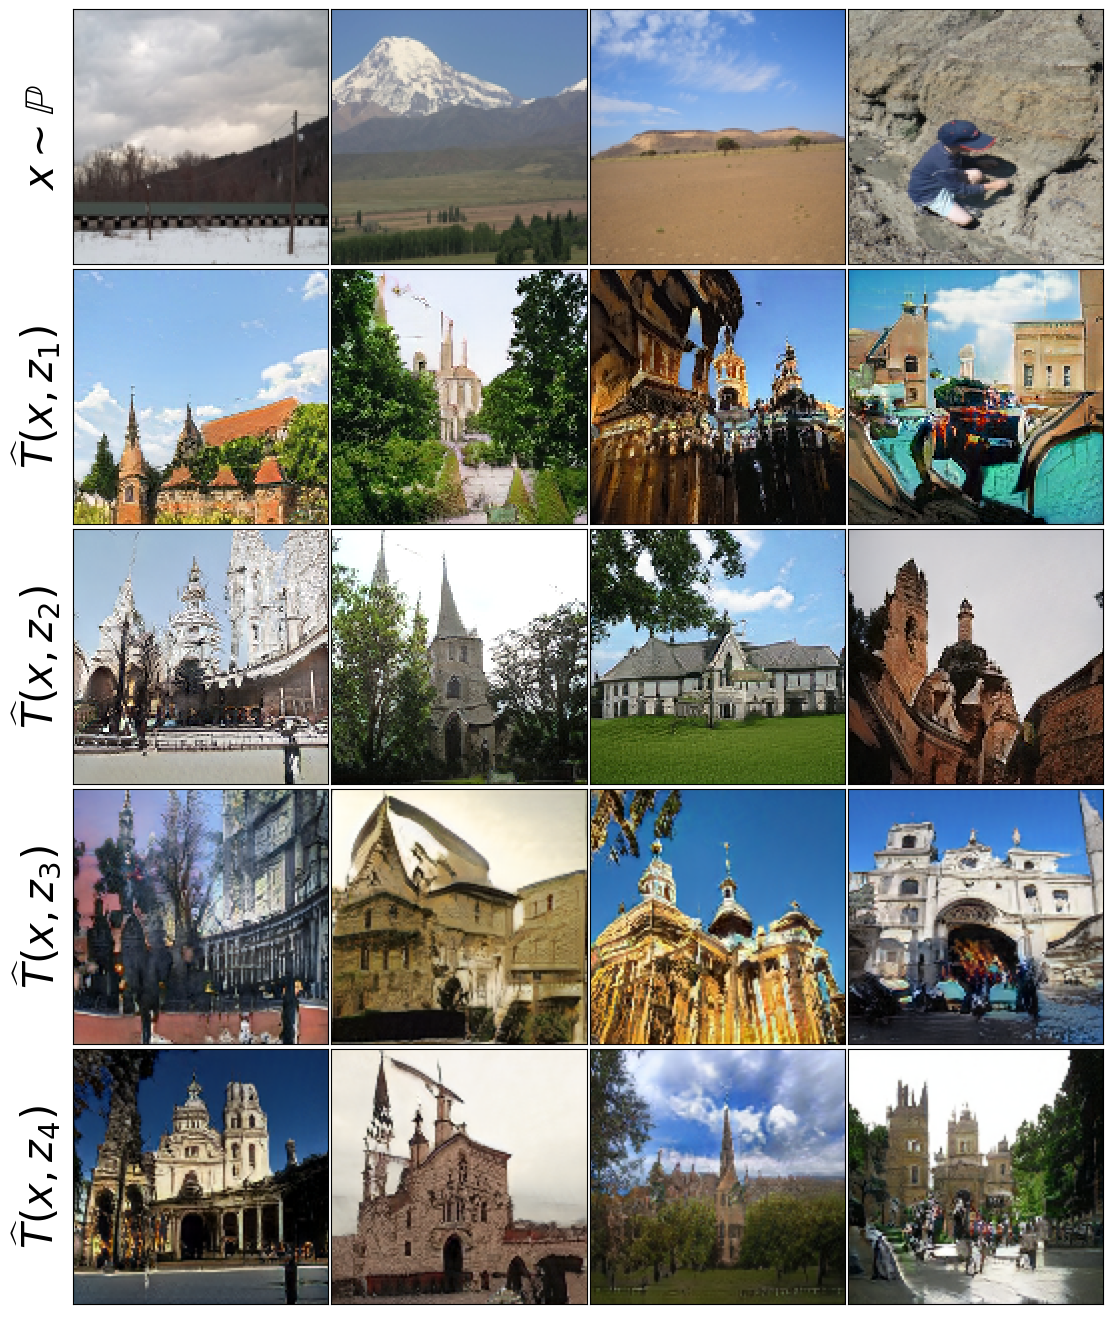

In [13]:
nets_ema = solver.nets_ema
nets_ema.mapping_network.eval()
nets_ema.generator.eval()

torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)

num_examples = 4
Y_test_fakes = []

Y_test_fakes = []

for v in range(num_examples):
    N = X_test_fixed.size(0)
    x_src = X_test_fixed.to(device)
    y_trg = torch.tensor([final_trg_index] * N).to(device)
    masks = nets_ema.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

    z_trg = torch.randn(N, args.latent_dim).to(device)
    s_trg = nets_ema.mapping_network(z_trg, y_trg)
    x_fake = nets_ema.generator(x=x_src, s=s_trg, masks=masks).detach()

    fake_Y_test_numpy = tensor2img(x_fake)
    Y_test_fakes.append(fake_Y_test_numpy)

real_X_test_numpy = tensor2img(X_test_fixed)
real_Y_test_numpy = tensor2img(Y_test_fixed)

fig, axes = plt.subplots(5, 4, figsize=(11, 13), dpi=100)
X_tensor = real_X_test_numpy
Y_tensor = real_Y_test_numpy
Y_fake_tensor = Y_test_fakes

for j in range(4):
    axes[0][j].imshow(X_tensor[j])
    axes[0][j].get_xaxis().set_visible(False)
    axes[0][j].set_yticks([])
    #axes[0][j].get_yaxis().set_visible(False)

for i in range(4):
    for j in range(4):
        cur_img = Y_fake_tensor[i][j]

        axes[i + 1][j].imshow(cur_img)
        axes[i + 1][j].get_xaxis().set_visible(False)
        axes[i + 1][j].set_yticks([])
        #axes[i + 1][j].get_yaxis().set_visible(False)
        
axes[0, 0].set_ylabel(r'$x\sim\mathbb{P}$', fontsize=30)
for j in range(4):
    title = '\widehat{T}(x,z_' + str(j+1) + ')'
    axes[j+1, 0].set_ylabel(r'${}$'.format(title), fontsize=30)
    
fig.tight_layout(pad=0.001)    
plt.savefig("starganv2_outdoor2church_test.png")

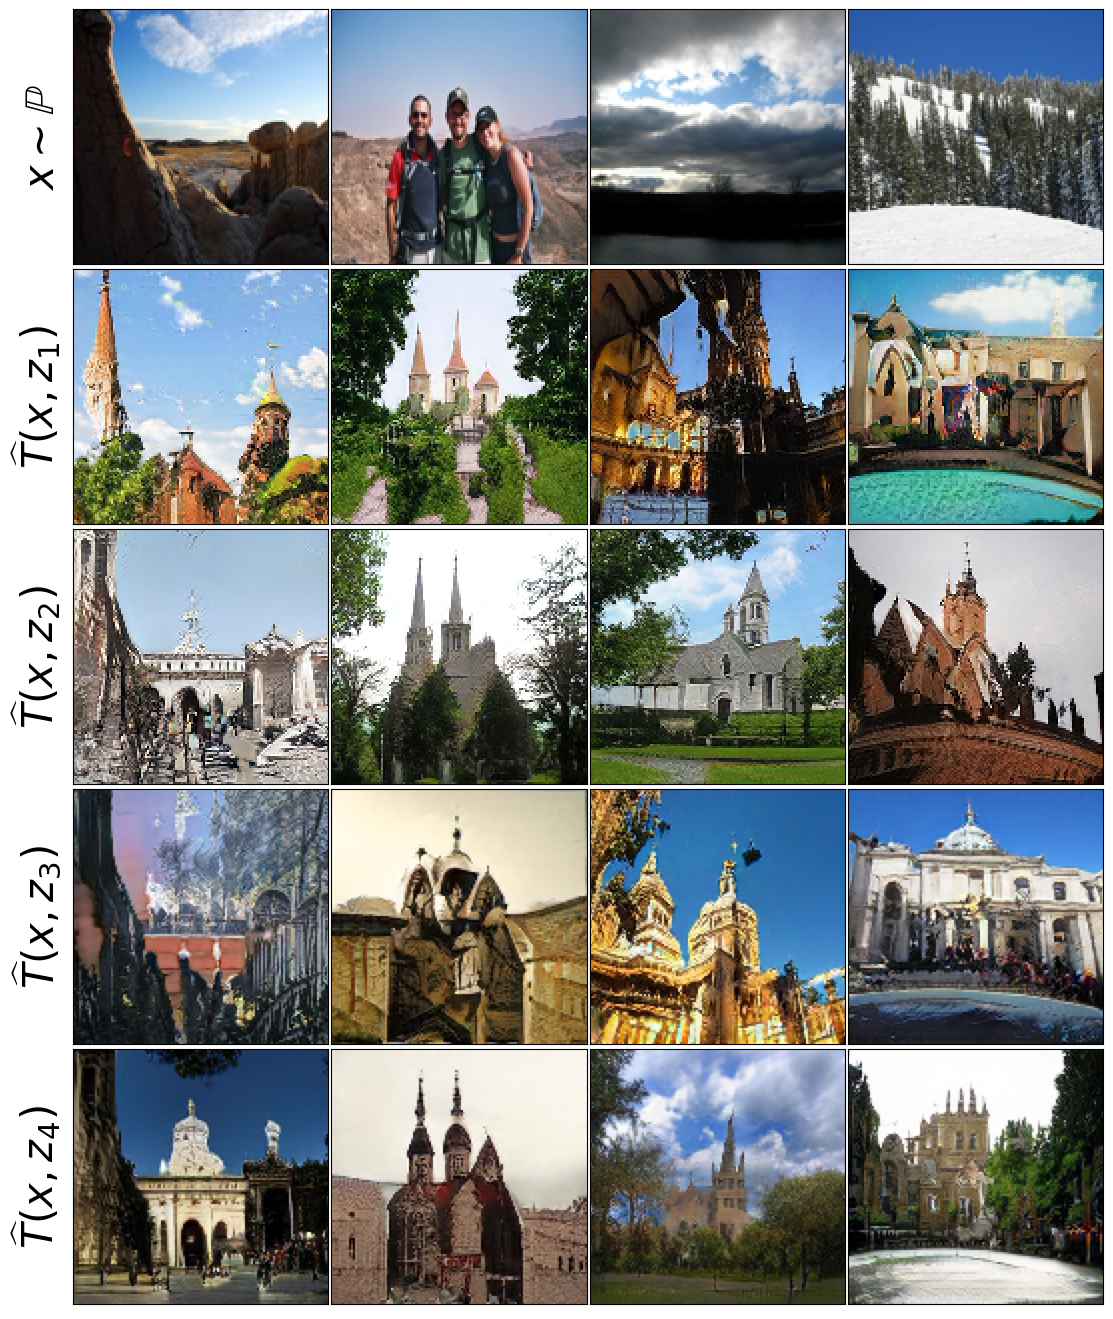

In [15]:
seed = 20

torch.manual_seed(seed)
np.random.seed(seed)

X_sampler = LoaderSampler(train_loader_a)
X_test_sampler = LoaderSampler(test_loader_a)
Y_sampler = LoaderSampler(train_loader_b)
Y_test_sampler = LoaderSampler(test_loader_b)

X_fixed = X_sampler.sample(10)
Y_fixed = Y_sampler.sample(10)

X_test_fixed = X_test_sampler.sample(10)
Y_test_fixed = Y_test_sampler.sample(10)

nets_ema = solver.nets_ema
nets_ema.mapping_network.eval()
nets_ema.generator.eval()

torch.manual_seed(0xBADBEEF)
np.random.seed(0xBADBEEF)

num_examples = 4
Y_test_fakes = []

Y_test_fakes = []

for v in range(num_examples):
    N = X_test_fixed.size(0)
    x_src = X_test_fixed.to(device)
    y_trg = torch.tensor([final_trg_index] * N).to(device)
    masks = nets_ema.fan.get_heatmap(x_src) if args.w_hpf > 0 else None

    z_trg = torch.randn(N, args.latent_dim).to(device)
    s_trg = nets_ema.mapping_network(z_trg, y_trg)
    x_fake = nets_ema.generator(x=x_src, s=s_trg, masks=masks).detach()

    fake_Y_test_numpy = tensor2img(x_fake)
    Y_test_fakes.append(fake_Y_test_numpy)

real_X_test_numpy = tensor2img(X_test_fixed)
real_Y_test_numpy = tensor2img(Y_test_fixed)

fig, axes = plt.subplots(5, 4, figsize=(11, 13), dpi=100)
X_tensor = real_X_test_numpy
Y_tensor = real_Y_test_numpy
Y_fake_tensor = Y_test_fakes

for j in range(4):
    axes[0][j].imshow(X_tensor[j])
    axes[0][j].get_xaxis().set_visible(False)
    axes[0][j].set_yticks([])
    #axes[0][j].get_yaxis().set_visible(False)

for i in range(4):
    for j in range(4):
        cur_img = Y_fake_tensor[i][j]

        axes[i + 1][j].imshow(cur_img)
        axes[i + 1][j].get_xaxis().set_visible(False)
        axes[i + 1][j].set_yticks([])
        #axes[i + 1][j].get_yaxis().set_visible(False)
        
axes[0, 0].set_ylabel(r'$x\sim\mathbb{P}$', fontsize=30)
for j in range(4):
    title = '\widehat{T}(x,z_' + str(j+1) + ')'
    axes[j+1, 0].set_ylabel(r'${}$'.format(title), fontsize=30)
    
fig.tight_layout(pad=0.001)    
plt.savefig("starganv2_outdoor2church_test2.png")